![A soccer pitch for an international match.](soccer-pitch.jpg)

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [4]:
# Pkg
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest
import pingouin

In [5]:
# Read data
women_raw = pd.read_csv('women_results.csv')
# print('Women data preview:\n{}'.format(women_raw.head()))
men_raw = pd.read_csv('men_results.csv')
# print('\nMen data preview:\n{}'.format(men_raw.head()))

In [6]:
# Concat data
women_raw['gender'] = 'W'
men_raw['gender'] = 'M'
data = pd.concat([women_raw,men_raw])
data['goals scored'] = data['home_score'] + data['away_score']

# Filter data with only tournament = FIFA World Cup
data_f = data[data['tournament'] == 'FIFA World Cup']

# Filter data with datetime start from 2002-01-01
data_f['date'] = pd.to_datetime(data_f['date'])
threshold_date = pd.Timestamp('2002-01-01')
data_f = data_f[data_f['date'] > threshold_date]

/var/folders/kw/_c93d7n916g47q0v46hsv4sw0000gn/T/ipykernel_75728/1792233764.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f['date'] = pd.to_datetime(data_f['date'])


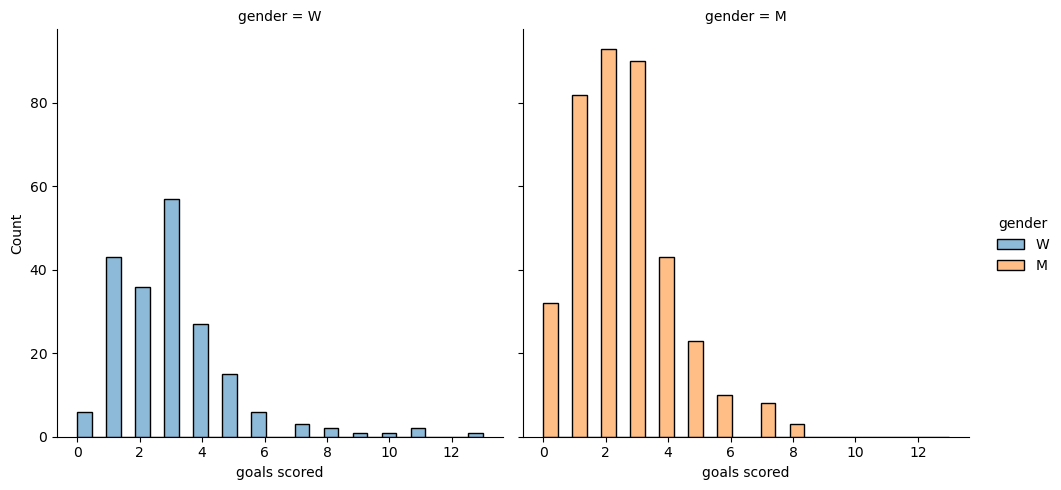

In [7]:
# Visualize the data
sns.displot(data=data_f, x='goals scored', hue='gender', kind='hist', col='gender')
plt.show()

In [8]:
# Normality check (KS test)
women_f = data_f[data_f['gender'] == 'W']
men_f = data_f[data_f['gender'] == 'M']
statistic_w, p_value_w = kstest(women_f['goals scored'], 'norm') # H_o: from normal
print("Woman's data KS statistic: {}, p-value: {}".format(statistic_w, p_value_w)) # reject H_o
statistic_m, p_value_m = kstest(men_f['goals scored'], 'norm')
print("Man's data KS statistic: {}, p-value: {}".format(statistic_m, p_value_m)) # reject H_o

Woman's data KS statistic: 0.8113447460685429, p-value: 9.431656241073109e-144
Man's data KS statistic: 0.7580114127352096, p-value: 4.802304083566536e-230


In [9]:
# Perform non-parametric Wilcoxon-Mann-Whitney test
pivoted_data = data_f[['gender', 'goals scored']].pivot(columns = 'gender', values = 'goals scored')
mwu_result = pingouin.mwu(x = pivoted_data['W'], y = pivoted_data['M'], alternative = 'greater')
p_val = np.array(mwu_result['p-val'])

In [10]:
# Test result
alpha = 0.1
result = ''
def r(p, a):
    if p <= a:
        result = 'reject'
    else:
        result = 'fail to reject'
    return(result)


result_dict = {"p_val": p_val[0], "result": r(p_val, alpha)}
print(result_dict)

{'p_val': 0.0051066098254436395, 'result': 'reject'}


In [11]:
### CLT method ###
from scipy.stats import norm
stat = data_f.groupby('gender')['goals scored'].agg(['mean', 'std', 'count'])
print(stat)
W_bar, M_bar = stat.loc['W','mean'], stat.loc['M','mean']
S_W, S_M = stat.loc['W','std'], stat.loc['M','std']
n_W, n_M = stat.loc['W','count'], stat.loc['M','count'] # both n_W and n_M > 30, the test statistic by clt is asymptotical to standard normal
z = (W_bar - M_bar) - 0 / (np.sqrt((S_W ** 2/n_W) +(S_M ** 2/n_M))) # 0.4669791666666665
p = 1 - norm.cdf(z, loc = 0, scale =1)
result_dict_clt = {"p_val": p, "result": r(p, alpha)}
print(result_dict_clt) 
# The CLT result is very different from the Mann-Whitney U test since the sample is clearly not draw from a normal distribution and in this situation performing a Mann-Whitney U test is more robust.

            mean       std  count
gender                           
M       2.513021  1.652544    384
W       2.980000  2.022387    200
{'p_val': 0.32025739173369594, 'result': 'fail to reject'}
